In [1]:
!pip install bertopic -q
!pip install inflect -q
!pip install contractions -q
!pip install pyldavis==3.4.0 -q
!pip install cartopy -q

In [2]:
# Imports libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import torch
import random


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import PartOfSpeech
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN


import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
# Download nltk packages
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("english")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Error loading english: Package 'english' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

<div style="display: flex; flex-direction: column; align-items: center; background-color: #00688B; padding: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Functions</h1>
</div>

## Exclude non-target literature

In [4]:
# Remove unnecessay columns and exclusive records
def data_cleaning(data):
    columns = ["Author full names", "Title", "Language of Original Document", "Abstract", 
               "Document Type", "Year", "Author Keywords", "Publication Stage", "Publisher", "Affiliations"]
    data = data[columns]
    
    # Number of paper
    print("Number of papers", len(data))

    # exclusive of non-English papers
    data = data[data["Language of Original Document"] == "English"]
    print("Number of English paper: ", len(data))

    # exclusive no absract papers
    data = data[~(data["Abstract"] == "[No abstract available]")]
    print("Number of paper with abstract: ", len(data))
    
    # Exclusive conference reivew
    data = data[~((data["Document Type"] == "Conference review") | (data["Document Type"] == "Erratum") | (data["Document Type"] == "Retracted"))]
    print("Number of paper without conference review: ", len(data))
    
    data.reset_index(drop=True, inplace=True)
    data["Year"] = data["Year"].astype(int)
    
    cleaned = data["Abstract"].str.lower()
    cleaned = cleaned.str.replace(r"(introduction|background|objective|purpose|conclusion|result|results|objectives):", "")
    cleaned = cleaned.apply(str).map(lambda x: re.sub(r"[!-/:-@\[-`{-~]"," ", x))
    cleaned = cleaned.apply(str).map(lambda x: re.sub(r"\d+", "", x))
    data["cleaned abstract"] = cleaned
    data["cleaned word count"] = data["cleaned abstract"].apply(lambda x: len(x.split()))
    
    data["Affiliations"] = data["Affiliations"].fillna("No Information")
    
    return data

## Lemmatise for topic representation

In [5]:
# Reference URL: https://github.com/MaartenGr/BERTopic/issues/286

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## Visualisation functions

In [6]:
# Visualise number of literature by document type
def vis_documentType(df):
    sorted_df = df["Document Type"].value_counts().reset_index().rename(columns={"index": "Document Type", "Document Type": "Count"})
    sorted_df = sorted_df.sort_values(by="Count", ascending=False)

    ax = sns.countplot(data=df, y="Document Type", color="#00688B", order=sorted_df["Document Type"])
    ax.bar_label(ax.containers[0])
    plt.show()
    
def vis_publication(df):
    # Publication
    palette = ["#E91E63", "#00BCD4", "#9C27B0", "#009688", "#FBC02D", "#F4511E", "#C0CA33", "#546E7A"]
    fig, ax = plt.subplots(figsize=(12, 4))
    
    pivot_df = df.pivot_table(index="Year", columns="Document Type", aggfunc="size", fill_value=0)
    palette = ["#E91E63", "#00BCD4", "#9C27B0", "#009688", "#FBC02D", "#F4511E", "#C0CA33", "#546E7A"]
    pivot_df.plot(kind="bar", stacked=True, ax=ax, color=palette)
    ax.set_xticklabels(pivot_df.index, rotation=45)
    ax.set(xlabel="Publication Year", ylabel="Number of studies")
    plt.legend(title="Document Type")
    plt.show()


In [7]:
def vis_country(df):
    tmp = df["Affiliations"].str.split(";", expand=True)[0]
    country = []
    for t in tmp:
        country.append(t.split(",")[-1])
    df["Country"] = country
    country_counts = df["Country"].value_counts()
    sorted_countries = country_counts.index
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax = sns.countplot(data=df, x="Country", color="#00688B", order=sorted_countries)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Apply conditional coloring based on the count
    for p, count in zip(ax.patches, country_counts):
        if count > 10:
            p.set_color("#E91E63")

    ax.bar_label(ax.containers[0])
    ax.set(xlabel="Country", ylabel="Number of studies")
    plt.show()

In [8]:
import geopandas as gpd
import cartopy.crs as ccrs

def vis_countrymap(df):
    tmp = df["Affiliations"].str.split(";", expand=True)[0]
    countries = []
    for t in tmp:
        countries.append(t.split(",")[-1])
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world['name'] = world['name'].str.strip().str.lower()
    countries = list(set(countries))
    target_countries = [c.strip().lower() for c in countries]
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()

    for index, country in world.iterrows():
        if country['name'] in target_countries:
            ax.add_geometries([country['geometry']], crs=ccrs.PlateCarree(), facecolor='#E91E63', edgecolor='grey')
        else:
            ax.add_geometries([country['geometry']], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='grey')

    ax.set_extent([-180, 180, -60, 90])
    plt.show()

In [9]:
def vis_umapresults(embeddings, n_neighbors_values, min_dist, random_state):

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("UMAP with Different n_neighbors_values")

    for i, n_neighbors in enumerate(n_neighbors_values):
        row = i // 3  # Determine the row for the current plot
        col = i % 3   # Determine the column for the current plot

        # Initialize UMAP model
        umap_model = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)

        # Generate UMAP embeddings
        umap_embeddings = umap_model.fit_transform(embeddings)

        # Use the appropriate subplot from the grid
        ax = axes[row, col]
        ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], alpha=0.25, cmap='Spectral', s=20)
        ax.set_title(f"n_neighbors = {n_neighbors}")

    # Adjust spacing and show the plot
    plt.tight_layout()
    plt.show()

In [10]:
def vis_hdbscanresults(umap_embeddings, n_neighbors, min_samples, min_cluster_sizes):

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("HDBSCAN Clustering with Different min_cluster_size Values")

    for i, min_cluster_size in enumerate(min_cluster_sizes):
        row = i // 3  # Determine the row for the current plot
        col = i % 3   # Determine the column for the current plot

        clusterer = HDBSCAN(min_cluster_size=min_cluster_size, 
        prediction_data=True,
        min_samples=min_samples,
        gen_min_span_tree=True).fit(umap_embeddings)
        color_palette = sns.color_palette('Paired', n_colors=max(clusterer.labels_) + 1)
        cluster_colors = [color_palette[x] if x >= 0
                          else (0.5, 0.5, 0.5)
                          for x in clusterer.labels_]
        cluster_member_colors = [sns.desaturate(x, p) for x, p in
                                 zip(cluster_colors, clusterer.probabilities_)]

        perplexity = 10
        projection = TSNE(perplexity=perplexity).fit_transform(umap_embeddings)

        # Use the appropriate subplot from the grid
        ax = axes[row, col]
        ax.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.5)
        ax.set_title(f"min_cluster_size = {min_cluster_size}")

    # Adjust spacing and show the plot
    plt.tight_layout()
    plt.show()

<div style="display: flex; flex-direction: column; align-items: center; background-color: #00688B; padding: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Fairness Corpus</h1>
</div>


**Search Terms: TITLE-ABS-KEY=(("medical" or "health*") and ("artificial intelligence" or "ai" or "machine learning" or "deep learning") and ("fairness"))**

In [11]:
fpath = "/kaggle/input/scopus-fairness-literature/General search fairness.csv"
df = pd.read_csv(fpath, encoding="unicode_escape", delimiter=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ï»¿"Authors"                   437 non-null    object 
 1   Author full names              437 non-null    object 
 2   Author(s) ID                   437 non-null    object 
 3   Title                          466 non-null    object 
 4   Year                           466 non-null    int64  
 5   Source title                   466 non-null    object 
 6   Volume                         326 non-null    object 
 7   Issue                          179 non-null    object 
 8   Art. No.                       159 non-null    object 
 9   Page start                     276 non-null    object 
 10  Page end                       268 non-null    object 
 11  Page count                     295 non-null    float64
 12  Cited by                       466 non-null    int

In [12]:
df = data_cleaning(df)

Number of papers 466
Number of English paper:  461
Number of paper with abstract:  448
Number of paper without conference review:  418


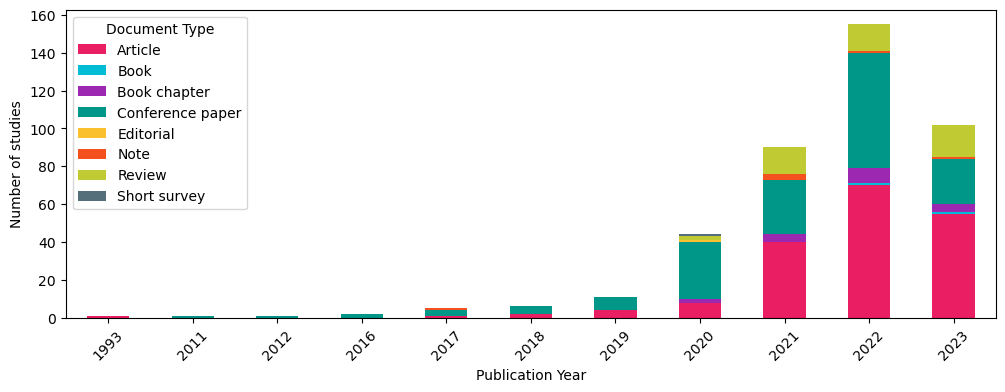

In [13]:
vis_publication(df)

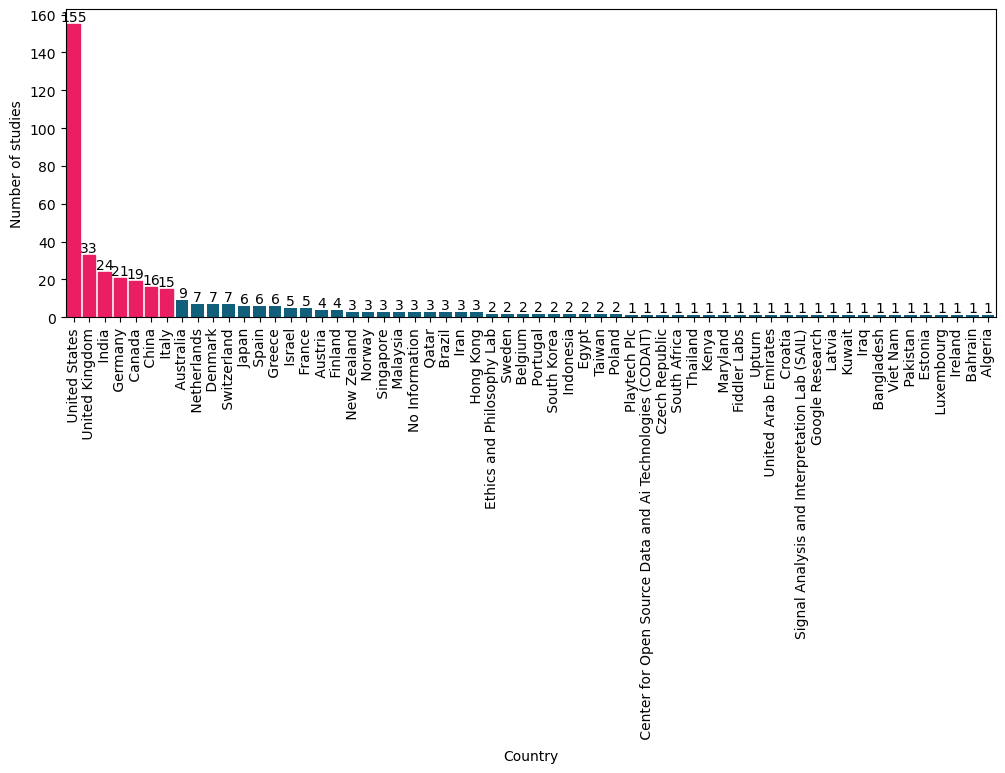

In [14]:
vis_country(df)

/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


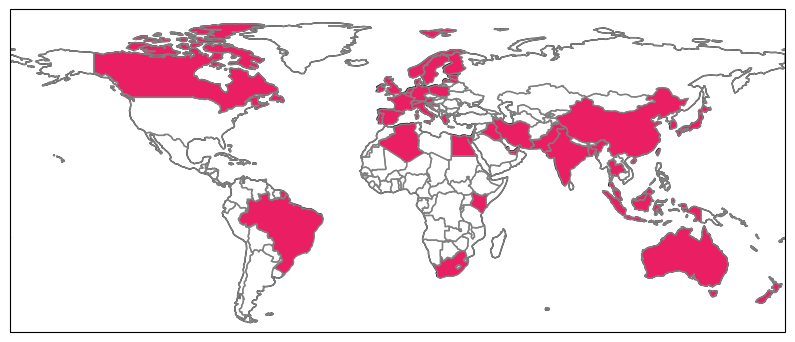

In [15]:
vis_countrymap(df)

In [16]:
# The publication is focused after 2020
index = df[df["Year"] < 2020].index
df.drop(index=index, inplace=True)
df.reset_index(drop=True, inplace=True)

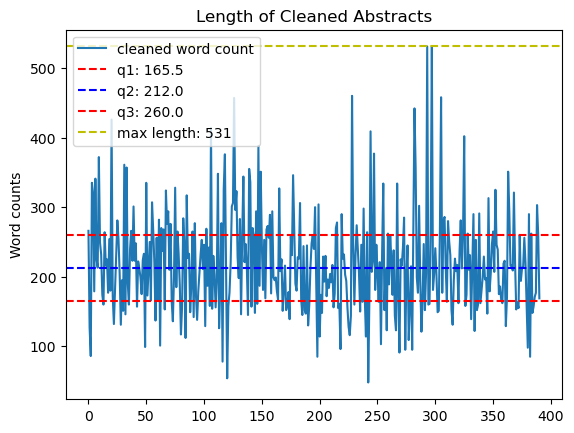

In [17]:
df["cleaned word count"].plot()
q1 = np.quantile(df["cleaned word count"], .25)
q2 = np.quantile(df["cleaned word count"], .50)
q3 = np.quantile(df["cleaned word count"], .75)
max_length = df["cleaned word count"].max(0)
plt.axhline(y=q1, color='r', linestyle='--', label='q1: ' + str(q1))
plt.axhline(y=q2, color='b', linestyle='--', label='q2: ' + str(q2))
plt.axhline(y=q3, color='r', linestyle='--', label='q3: ' + str(q3))
plt.axhline(y=max_length, color='y', linestyle='--', label='max length: ' + str(max_length))

plt.ylabel("Word counts")
plt.title("Length of Cleaned Abstracts")
plt.legend()
plt.show()

In [18]:
"""
from transformers import BartForConditionalGeneration, BartTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = 'facebook/bart-large-cnn'
tokenizer = BartTokenizer.from_pretrained(model_name)
summary = BartForConditionalGeneration.from_pretrained(model_name).to(device)

docs = list(df["cleaned abstract"])
summaries = []

for doc in docs:
    inputs = tokenizer(doc, return_tensors="pt", max_length=max_length, truncation=True).to(device)
    s_ids = summary.generate(inputs["input_ids"], num_beams=4, max_length=100, early_stopping=True)
    s = tokenizer.decode(s_ids[0], skip_special_tokens=True)
    summaries.append(s)
    
df["summarised abstract"] = summaries

"""

'\nfrom transformers import BartForConditionalGeneration, BartTokenizer\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\n\nmodel_name = \'facebook/bart-large-cnn\'\ntokenizer = BartTokenizer.from_pretrained(model_name)\nsummary = BartForConditionalGeneration.from_pretrained(model_name).to(device)\n\ndocs = list(df["cleaned abstract"])\nsummaries = []\n\nfor doc in docs:\n    inputs = tokenizer(doc, return_tensors="pt", max_length=max_length, truncation=True).to(device)\n    s_ids = summary.generate(inputs["input_ids"], num_beams=4, max_length=100, early_stopping=True)\n    s = tokenizer.decode(s_ids[0], skip_special_tokens=True)\n    summaries.append(s)\n    \ndf["summarised abstract"] = summaries\n\n'

<div style="display: flex; flex-direction: column; align-items: center; background-color: #00688B; padding: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">BERTopic</h1>
</div>

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

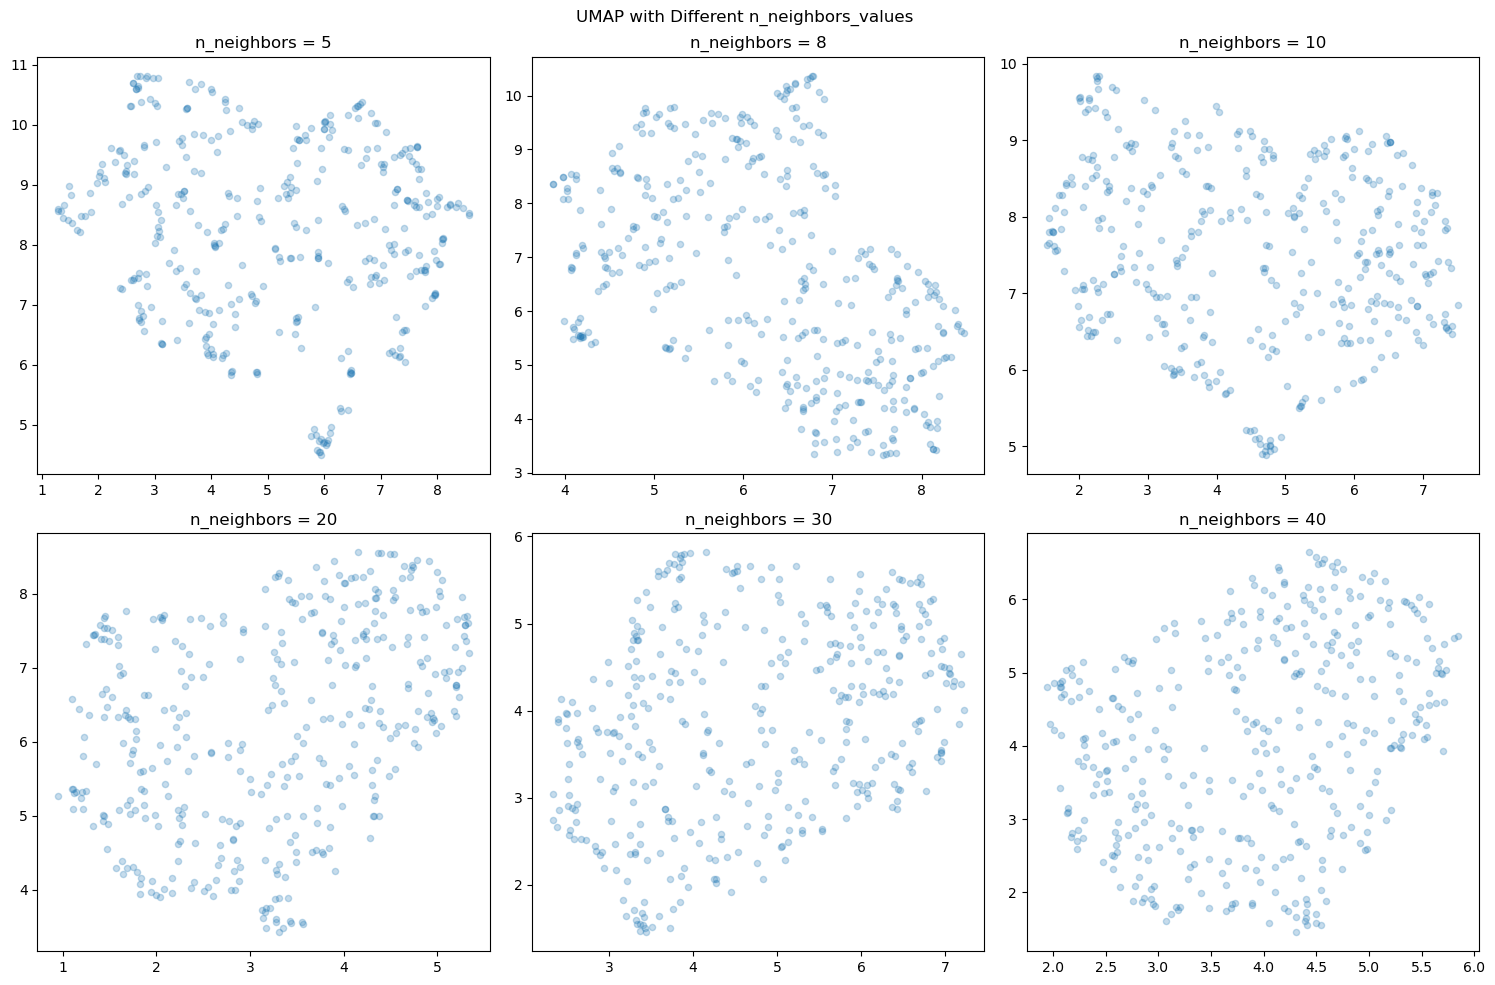

In [19]:
random_state = 42
min_dist = 0.0
n_neighbors_values = [5, 8, 10, 20, 30, 40]

embedding_model = SentenceTransformer("allenai/scibert_scivocab_uncased", device="cuda")
embeddings = embedding_model.encode(df["cleaned abstract"])

# embeddings = embedding_model.encode(df["summarised abstract"])

vis_umapresults(embeddings, n_neighbors_values, min_dist, random_state)

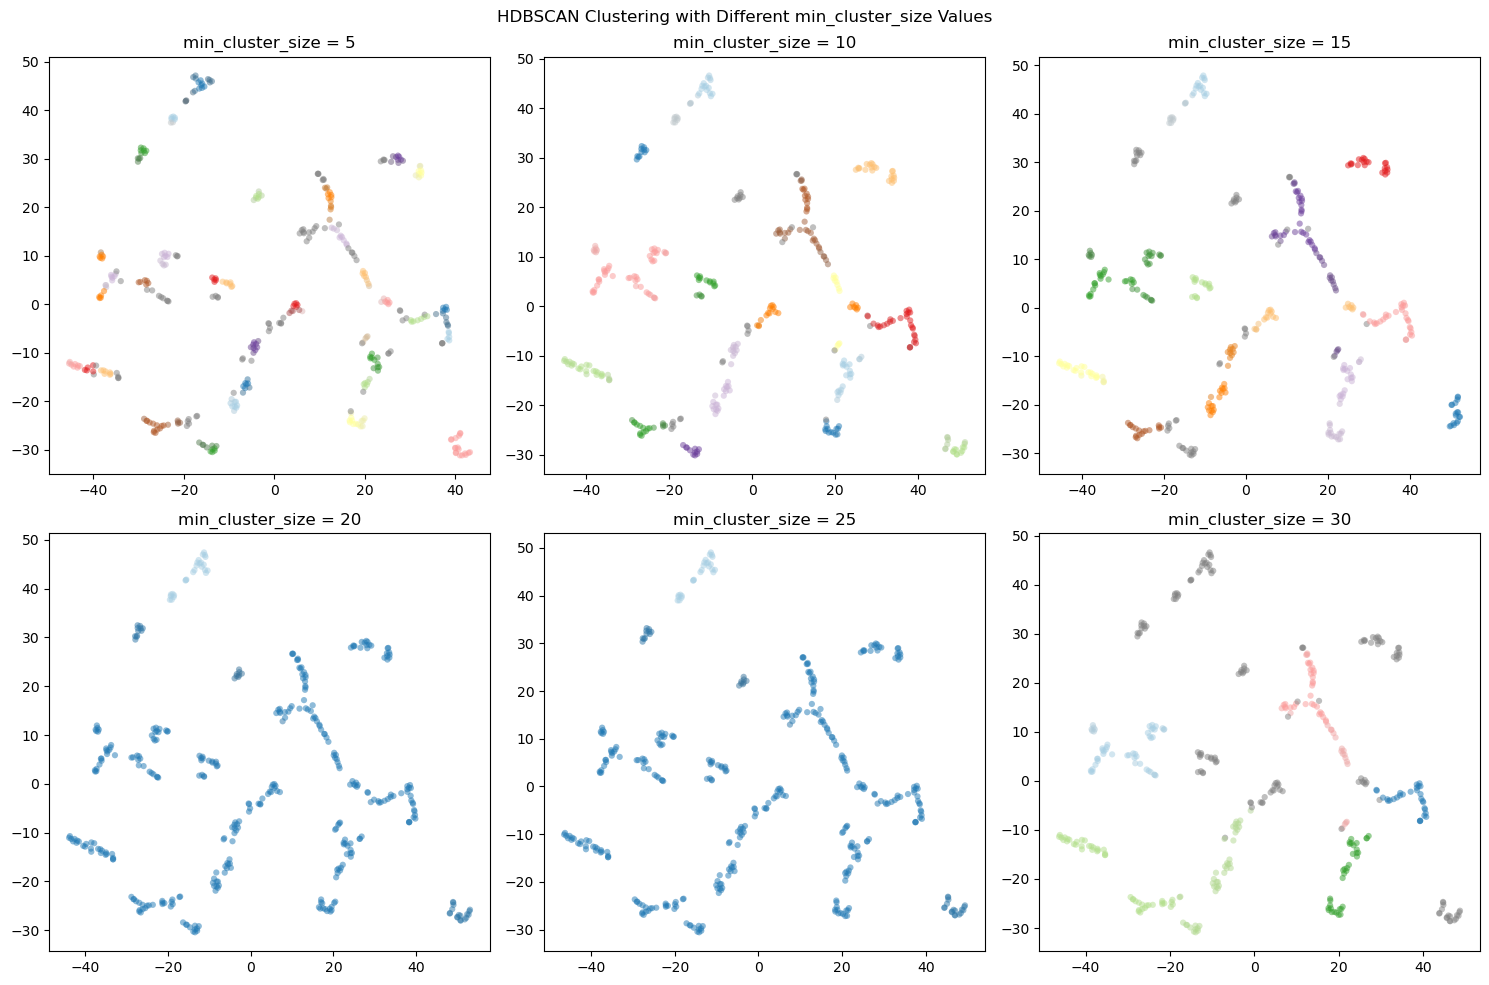

In [20]:
n_neighbors = 5
min_samples = 2
min_cluster_sizes = [5, 10, 15, 20, 25, 30]

# decided UMAP
umap_model = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
umap_embeddings = umap_model.fit_transform(embeddings)

vis_hdbscanresults(umap_embeddings, n_neighbors, min_samples, min_cluster_sizes)

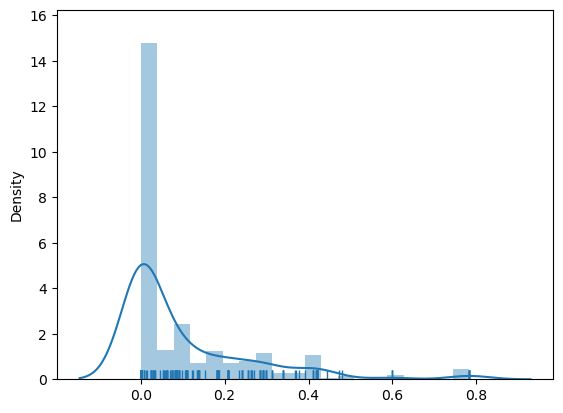

In [21]:
# Outlier detection, min_cluster_size has decided by the result
min_cluster_size = 10
hdbscan_model = HDBSCAN(
    min_cluster_size=min_cluster_size, 
    prediction_data=True,
    min_samples=min_samples,
    gen_min_span_tree=True).fit(umap_embeddings)
sns.distplot(hdbscan_model.outlier_scores_[np.isfinite(hdbscan_model.outlier_scores_)], rug=True)
plt.show()

In [22]:
df["outlier score"] = hdbscan_model.outlier_scores_
print(len(df[df["outlier score"] > 0.5]))
df[df["outlier score"] > 0.5]["Abstract"]

10


3      Diabetic retinopathy (DR), a leading cause of ...
33     Background: Resources are increasingly spent o...
50     Objective: The proper handling of missing valu...
67     One of the difficulties of artificial intellig...
85     Machine learning models have been increasingly...
100    According to the FAIR principles, data produce...
106    Introduction: Developments in Artificial Intel...
189    Background: Machine learning (ML) has spread r...
232    Objective: This study aimed to obtain suggesti...
362    Despite being the fastest-growing field becaus...
Name: Abstract, dtype: object

In [23]:
top_n_words = 20
ngram_range = (1, 3)

stop_words = stopwords.words("english")
stop_words.extend(["artificial intelligence", "machine learning", "healthcare"])

In [24]:
from bertopic import representation
# UMAP reference https://umap-learn.readthedocs.io/en/latest/parameters.html
# HDBSCAN reference https://hdbscan.readthedocs.io/en/latest/parameter_selection.html
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
import collections

# classed TF-IDF topic representation words
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)

vectorizer_model = CountVectorizer(max_df=0.8, min_df=2, stop_words=stop_words, 
                                   strip_accents="ascii", tokenizer=LemmaTokenizer(),
                                  ngram_range=ngram_range)

# Fine-tuning for representation
# representation_model = KeyBERTInspired(top_n_words=20)
# representation_model = MaximalMarginalRelevance(diversity=0.5)
representation_model = PartOfSpeech("en_core_web_sm")


# modelling
model = BERTopic(
    language="english",
    top_n_words=top_n_words,
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    calculate_probabilities=True)

topics, probs = model.fit_transform(df["cleaned abstract"], embeddings)
# topics, probs = model.fit_transform(df["summarised abstract"], embeddings)

n_topics = (len(collections.Counter(topics)))
print("Number of topics", n_topics - 1) # Without outliers

df["Topic"] = topics

Number of topics 16


In [25]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,29,-1_disparity_regression_day_formula,"[disparity, regression, day, formula, project,...",[the growing use of machine learning in policy...
1,0,49,0_ethical_algorithmic_harm_wellbeing,"[ethical, algorithmic, harm, wellbeing, practi...",[the increasing use of artificial intelligence...
2,1,40,1_dataset_racial_skin_identification,"[dataset, racial, skin, identification, race, ...",[with the rise of ai algorithms have become b...
3,2,30,2_satisfaction_stock_component_trust,"[satisfaction, stock, component, trust, explan...",[this paper investigates the applications of e...
4,3,28,3_algorithmic_virtual_computational_algorithmi...,"[algorithmic, virtual, computational, algorith...",[machine learning based systems and products a...
5,4,26,4_imputation_dental_database_race,"[imputation, dental, database, race, calibrati...",[ racial bias is a key concern regarding the d...
6,5,26,5_food_discrimination_algorithmic_article,"[food, discrimination, algorithmic, article, n...",[ the coronavirus disease pandemic has placed...
7,6,22,6_agent_allocation_shift_heterogeneous,"[agent, allocation, shift, heterogeneous, feas...",[model interpretability fairness and recours...
8,7,21,7_tree_causal_causal inference_constraint,"[tree, causal, causal inference, constraint, a...",[causal inference is a fundamental concept tha...
9,8,21,8_older_fl_adult_gradient,"[older, fl, adult, gradient, activity, archite...",[wireless wearable sensor networks wsn based...


In [26]:
"""
new_topics = model.reduce_outliers(df["cleaned abstract"], topics)
model.update_topics(df["cleaned abstract"], 
                    topics=new_topics,
                    vectorizer_model=vectorizer_model,
                    ctfidf_model=ctfidf_model,
                    #representation_model=representation_model
                   )
df["Topic"] = new_topics
n_topics = len(set(new_topics))

model.get_topic_info()
"""


'\nnew_topics = model.reduce_outliers(df["cleaned abstract"], topics)\nmodel.update_topics(df["cleaned abstract"], \n                    topics=new_topics,\n                    vectorizer_model=vectorizer_model,\n                    ctfidf_model=ctfidf_model,\n                    #representation_model=representation_model\n                   )\ndf["Topic"] = new_topics\nn_topics = len(set(new_topics))\n\nmodel.get_topic_info()\n'

In [27]:
model.visualize_barchart(top_n_topics=n_topics, n_words=10)

In [28]:
words = pd.DataFrame(model.get_topic_info()["Representation"])
words = words["Representation"].apply(pd.Series)
words = words.rename(columns=lambda x: f"word_{x + 1}")
words = pd.concat([model.get_topic_info(), words], axis=1)
words

,Topic,Count,Name,Representation,Representative_Docs,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10
0,-1,29,-1_disparity_regression_day_formula,"[disparity, regression, day, formula, project,...",[the growing use of machine learning in policy...,disparity,regression,day,formula,project,policy,infection,depression,sentiment,synthetic
1,0,49,0_ethical_algorithmic_harm_wellbeing,"[ethical, algorithmic, harm, wellbeing, practi...",[the increasing use of artificial intelligence...,ethical,algorithmic,harm,wellbeing,practice,legal,stakeholder,automatic,bda,consideration
2,1,40,1_dataset_racial_skin_identification,"[dataset, racial, skin, identification, race, ...",[with the rise of ai algorithms have become b...,dataset,racial,skin,identification,race,gender,disparity,sex,de,subgroup
3,2,30,2_satisfaction_stock_component_trust,"[satisfaction, stock, component, trust, explan...",[this paper investigates the applications of e...,satisfaction,stock,component,trust,explanation,manipulation,tai,explainable,xai,blockchain
4,3,28,3_algorithmic_virtual_computational_algorithmi...,"[algorithmic, virtual, computational, algorith...",[machine learning based systems and products a...,algorithmic,virtual,computational,algorithmic bias,sex,laboratory,contact,rcts,overview,gender
5,4,26,4_imputation_dental_database_race,"[imputation, dental, database, race, calibrati...",[ racial bias is a key concern regarding the d...,imputation,dental,database,race,calibration,audit,subgroup,dr,racial bias,age
6,5,26,5_food_discrimination_algorithmic_article,"[food, discrimination, algorithmic, article, n...",[ the coronavirus disease pandemic has placed...,food,discrimination,algorithmic,article,non discrimination,product,medical ai,responsibility,medical machine,region
7,6,22,6_agent_allocation_shift_heterogeneous,"[agent, allocation, shift, heterogeneous, feas...",[model interpretability fairness and recours...,agent,allocation,shift,heterogeneous,feasibility,function,shapley,classifier,community,welfare
8,7,21,7_tree_causal_causal inference_constraint,"[tree, causal, causal inference, constraint, a...",[causal inference is a fundamental concept tha...,tree,causal,causal inference,constraint,assurance,goal,incentive,attack,inference,fat
9,8,21,8_older_fl_adult_gradient,"[older, fl, adult, gradient, activity, archite...",[wireless wearable sensor networks wsn based...,older,fl,adult,gradient,activity,architecture,skinned,meta learning,experiment,weight


In [29]:
words.to_csv("words.csv")

In [30]:
df.to_csv("review.csv")

In [31]:
hierarchical_topics = model.hierarchical_topics(df["cleaned abstract"])
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


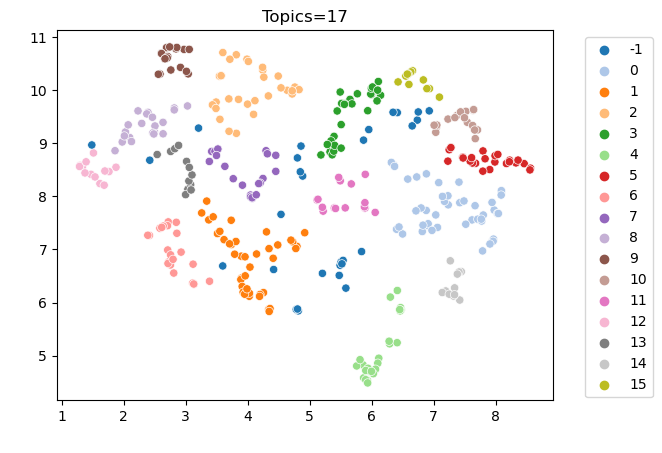

In [32]:
df["umap x"] = umap_embeddings[:, 0]
df["umap y"] = umap_embeddings[:, 1]

topic_colors = sns.color_palette("tab20", n_colors=24)
sns.scatterplot(data=df, x="umap x", y="umap y", hue="Topic", palette=topic_colors)
plt.title(f"Topics={n_topics}")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(" ")
plt.ylabel(" ")
plt.show()

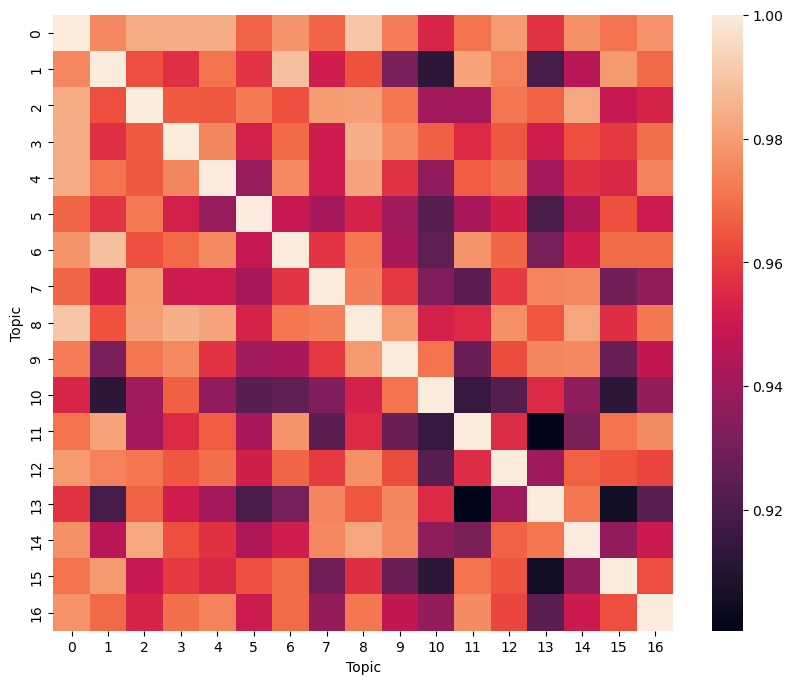

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(model.topic_embeddings_, model.topic_embeddings_)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix)
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()

In [34]:
model.visualize_documents(df["cleaned abstract"], embeddings=embeddings, hide_document_hover=True)

In [35]:
# For words level analysis
df_represented_words = model.get_topic_info().copy()
df_represented_words["Representation"] = df_represented_words["Representation"].astype(str)
df_represented_words["Representation"] = df_represented_words["Representation"].str.replace("[", "")
df_represented_words["Representation"] = df_represented_words["Representation"].str.replace("]", "")

In [36]:
timestamps = pd.to_datetime(df["Year"], format="%Y")
topics_over_time = model.topics_over_time(df["cleaned abstract"], timestamps, global_tuning=True, evolution_tuning=True, nr_bins=20)
model.visualize_topics_over_time(topics_over_time, topics=list(df_represented_words["Topic"]))

In [37]:
words = vectorizer_model.get_feature_names_out()
print(len(words))

X = vectorizer_model.transform(df["cleaned abstract"])
X = X.toarray()

7208


In [38]:
df_words = pd.DataFrame(X, columns=words)
df_words_sumup = pd.DataFrame(df_words.sum(), columns=["count"])
df_words_sumup.reset_index(names="word", inplace=True)

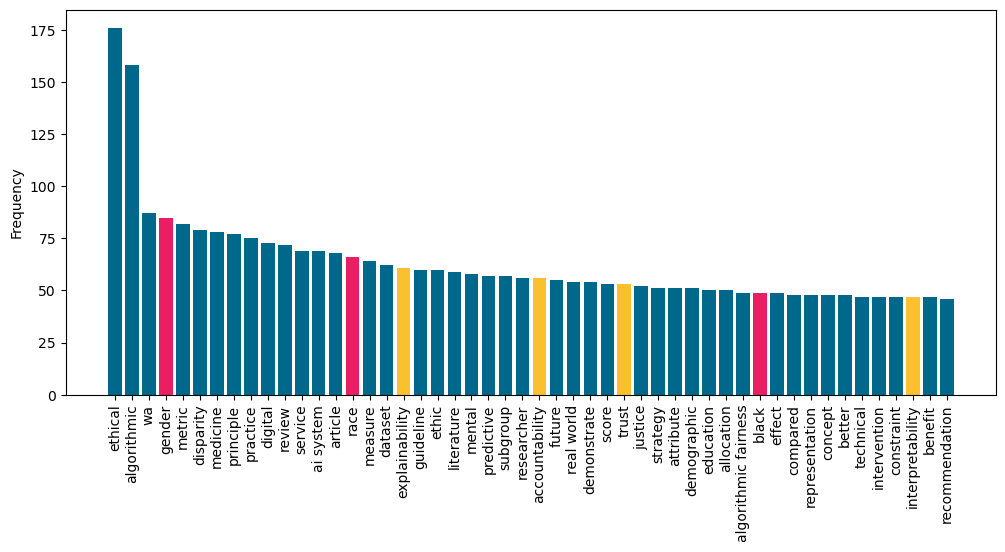

In [39]:
plt.figure(figsize=(12, 5))
df_words_sumup_graph = df_words_sumup.sort_values(by="count", ascending=False).head(50)
sensitive_attributes = ["gender", "race", "black"]
trustworthiness_words = ["explainability", "trust", "accountability", "interpretability"]

colors = [
    "#E91E63" if label in sensitive_attributes else
    "#FBC02D" if label in trustworthiness_words else
    "#00688B" for label in df_words_sumup_graph["word"]]
plt.bar(df_words_sumup_graph["word"], df_words_sumup_graph["count"], color=colors)

plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.show()


In [40]:
X.shape

(391, 7208)

<div style="display: flex; flex-direction: column; align-items: center; background-color: #00688B; padding: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">LDA</h1>
</div>

In [41]:
# Add pos tag to accurately lemmatise
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    elif treebank_tag.startswith('MD'):
        return 'v'  # Modal verb
    elif treebank_tag.startswith('PRP'):
        return 'n'  # Personal pronoun
    else:
        return 'n'  # Default to noun if the POS tag is unknown

In [42]:
import inflect # plural to singular
import contractions # thats to that is

def lemma(sentence):
    lemmatizer = WordNetLemmatizer()
    inflector = inflect.engine()
    expanded_sentence = contractions.fix(sentence)
    tokens = word_tokenize(expanded_sentence)
    pos_tags = pos_tag(tokens)
    lemmas = []
    for token, pos in pos_tags:
        if pos == 'NNS':  # Plural noun
            singular = inflector.singular_noun(token)
            lemma = singular if singular else token
        elif pos in ['RB', 'RBR', 'RBS', "UH", "PRP", "PRP$", "DT"]:  # Adverb, interjection
            continue  # Skip adverbs
        elif pos == 'VBZ':  # Third-person singular verb
            lemma = token[:-1]  # Remove the 's' ending
        else:
            wordnet_pos = get_wordnet_pos(pos)
            lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmas.append(lemma)
    return " ".join(lemmas)

In [43]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    additional_stop_words = ["health", "use", "study", "machine learning", "artificial intelligence"]
    stop_words.update(additional_stop_words)
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return " ".join(filtered_tokens)

In [44]:
df["lda abstract"] = [remove_stopwords(lemma(s)) for s in df["cleaned abstract"]]

In [45]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

documents = df["lda abstract"]

# Tokenize the documents
tokenized_docs = [simple_preprocess(doc) for doc in documents]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_docs)

# Convert the tokenized documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [46]:
# Define a list of candidate numbers of topics
num_topics_list = [i for i in range(10, 20, 1)]
random_state = 42

# Train LDA models with different numbers of topics
# lda_models = []
perplexity_scores = []
coherence_scores = []
for num_topics in num_topics_list:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=random_state, passes=5)

    # Perplexity score
    perplexity_score = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity_score)
    # coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    print("Num of Topics: ", num_topics)
    print("Perplexity score: ", perplexity_score)
    print("Coherence score: ", coherence_score)

Num of Topics:  10
Perplexity score:  -7.577662178468361
Coherence score:  0.34349696991363693
Num of Topics:  11
Perplexity score:  -7.5881393243512445
Coherence score:  0.33900085824450293
Num of Topics:  12
Perplexity score:  -7.6162227806231755
Coherence score:  0.31957942876445533
Num of Topics:  13
Perplexity score:  -7.642063486286344
Coherence score:  0.32182888836642903
Num of Topics:  14
Perplexity score:  -7.64999271214006
Coherence score:  0.34686474927531535
Num of Topics:  15
Perplexity score:  -7.678017228462029
Coherence score:  0.33798008581724087
Num of Topics:  16
Perplexity score:  -7.689671107793654
Coherence score:  0.3299426818665277
Num of Topics:  17
Perplexity score:  -7.710365493243334
Coherence score:  0.3426207706556815
Num of Topics:  18
Perplexity score:  -7.7243311047922045
Coherence score:  0.3278349983914025
Num of Topics:  19
Perplexity score:  -7.725053180067877
Coherence score:  0.3260948696661972


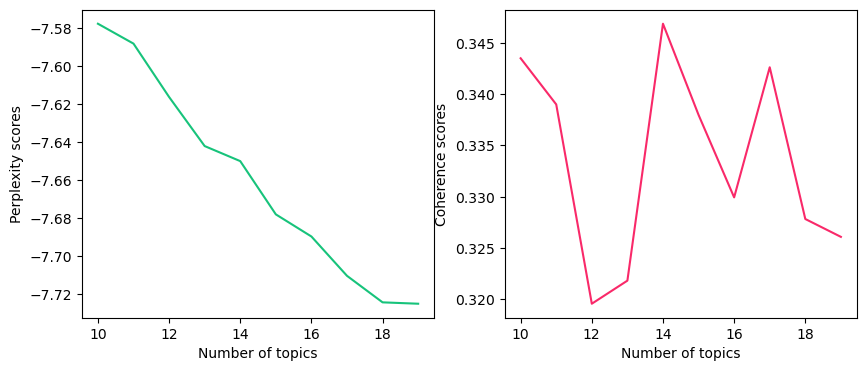

In [47]:
# visualisation
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(num_topics_list, perplexity_scores, color="#17C37B")
ax[0].set_xlabel("Number of topics")
ax[0].set_ylabel("Perplexity scores")
ax[1].plot(num_topics_list, coherence_scores, color="#F92969")
ax[1].set_xlabel("Number of topics")
ax[1].set_ylabel("Coherence scores")
plt.show()

In [48]:
# The LDA model
num_topics = 14
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=random_state, passes=10)

# Extract words from the inferred topics
# Number of words to be presented for each topic. These will be the most relevant words
topics = lda_model.show_topics(num_words=30, num_topics=num_topics)
sorted_topics = sorted(topics, key=lambda x: x[0])  # Sort topics by topic number

topic_words_list = []
for topic in sorted_topics:
    topic_num = topic[0]
    topic_words = topic[1].split('"')[1::2]  # Extract words between double quotes
    topic_words_list.append(topic_words)
    print(f"Topic {topic_num + 1} words: {topic_words}")

Topic 1 words: ['fairness', 'machine', 'decision', 'learn', 'learning', 'datum', 'human', 'ai', 'algorithm', 'ha', 'application', 'technology', 'healthcare', 'algorithmic', 'base', 'intervention', 'device', 'system', 'activity', 'research', 'paper', 'enable', 'model', 'social', 'improve', 'different', 'ml', 'wellbeing', 'er', 'processing']
Topic 2 words: ['fairness', 'model', 'social', 'base', 'datum', 'research', 'algorithmic', 'patient', 'ai', 'decision', 'group', 'medical', 'make', 'method', 'care', 'factor', 'system', 'healthcare', 'provide', 'imputation', 'satisfaction', 'feature', 'show', 'algorithm', 'high', 'machine', 'service', 'income', 'person', 'ha']
Topic 3 words: ['model', 'learn', 'fairness', 'datum', 'learning', 'machine', 'decision', 'bias', 'base', 'system', 'privacy', 'medical', 'healthcare', 'ml', 'ha', 'method', 'dataset', 'ai', 'issue', 'result', 'prediction', 'approach', 'may', 'research', 'accuracy', 'clinical', 'technique', 'deep', 'author', 'device']
Topic 4 w

In [49]:
# df = df.drop(df.columns[15:], axis=1)

In [50]:
# Connect documents and topics
highest_prob_topics = []
for doc_id in range(len(corpus)):
    topic_distribution = lda_model.get_document_topics(corpus[doc_id])
    highest_prob_topic = max(topic_distribution, key=lambda x: x[1])
    highest_prob_topics.append(highest_prob_topic)

df_topics = pd.DataFrame(highest_prob_topics, columns=["lda topic", "probability"])
df_topics["lda topic"] = df_topics["lda topic"].astype(int) + 1
df = pd.concat([df, df_topics], axis=1)

In [51]:
df_topics

,lda topic,probability
0,3,0.993849
1,12,0.986341
2,1,0.635020
3,3,0.926041
4,3,0.995060
...,...,...
386,3,0.991707
387,1,0.843406
388,1,0.508541
389,4,0.849626


In [52]:
# df = df.drop(df.columns[15:], axis=1)
df["lda topic"] = df["lda topic"].astype(str)
gr_topics = df.groupby("lda topic")["lda topic"].count().reset_index(name="count")
num_topics = len(gr_topics)
gr_topics

,lda topic,count
0,1,32
1,10,31
2,11,12
3,12,56
4,13,45
5,14,48
6,2,17
7,3,41
8,4,26
9,5,47


In [53]:
topic_score_list = []
for n in range(num_topics):
    topic_score_list.append(lda_model.show_topic(n))

df_scores = pd.DataFrame()

for i, t in enumerate(topic_score_list):
    df_tmp = pd.DataFrame(t, columns=["word", "score"])
    df_tmp["lda topic"] = i + 1
    df_scores = pd.concat([df_scores, df_tmp], ignore_index=True)

In [54]:
df_scores["lda topic"] = df_scores["lda topic"].astype(str)
num_topics = len(gr_topics)
topic_list = list(gr_topics["lda topic"])

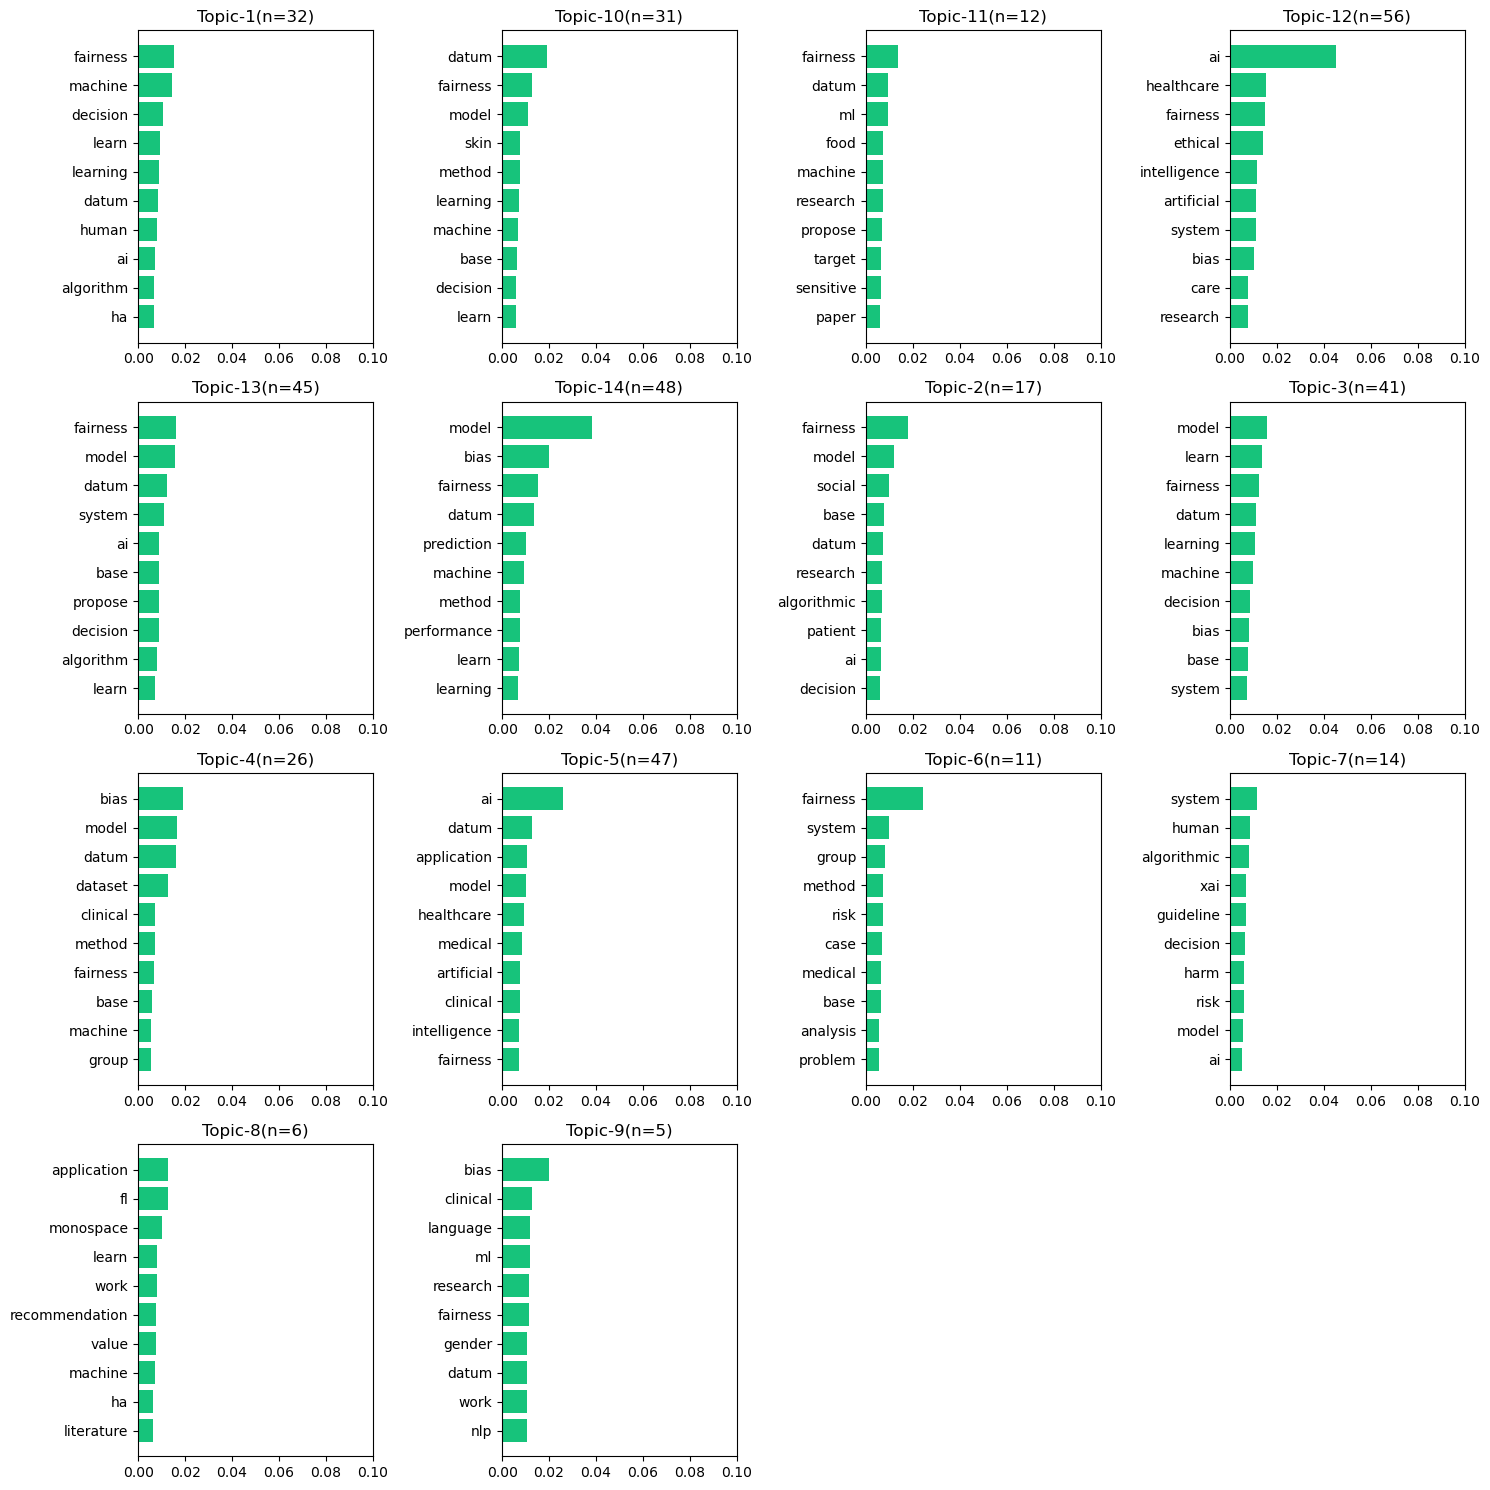

In [55]:
row = 4
col = 4
fig, ax = plt.subplots(row, col, figsize=(15, 15))

cnt = 0
for i in range(row):
    for j in range(col):
        if cnt >= num_topics:
            ax[i, j].axis('off')
        else:
            df_score = df_scores[df_scores["lda topic"] == topic_list[cnt]].sort_values(by="score")
            ax[i, j].barh(df_score["word"], df_score["score"], color="#17C37B")
            ax[i, j].set_title("Topic-" + topic_list[cnt] + "(n=" + str(gr_topics[gr_topics["lda topic"] == topic_list[cnt]]["count"].values[0]) + ")")
            ax[i, j].set_xlim(0, 0.1)
        cnt = cnt + 1
plt.tight_layout()
plt.show()

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(p, 'lda_visualization.html')
p

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.007449  0.051673       1        1   7.438085
1      0.009985  0.004436       2        1   4.392427
2     -0.067537  0.013096       3        1  10.100503
3     -0.106265 -0.113190       4        1   7.310017
4     -0.013011  0.113416       5        1  13.037645
5      0.056111 -0.049178       6        1   2.667263
6      0.065690  0.042167       7        1   3.256008
7      0.146123 -0.057347       8        1   1.397300
8      0.107600 -0.068322       9        1   1.251991
9     -0.056619 -0.008323      10        1   6.919974
10     0.035945 -0.010910      11        1   2.841792
11    -0.009496  0.140298      12        1  14.079415
12    -0.052839  0.025071      13        1  12.154934
13    -0.108236 -0.082885      14        1  13.152647, topic_info=            Term        Freq       Total Category  logprob  loglift
115         bias  397.000000  397.000000  Default  30.0000  30.0000
111           ai  659.000000  659.000000  Default  29.0000  29.0000
34      fairness  656.000000  656.000000  Default  28.0000  28.0000
163  application  234.000000  234.000000  Default  27.0000  27.0000
87      research  201.000000  201.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
8           base   39.200263  291.573530  Topic14  -5.1395   0.0219
214      dataset   31.561648  176.015025  Topic14  -5.3562   0.3099
112    algorithm   33.598881  214.082329  Topic14  -5.2937   0.1767
418      propose   30.172321  168.098914  Topic14  -5.4012   0.3109
509       across   23.331622   85.296058  Topic14  -5.6584   0.7322

[1073 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4482      4  0.899521             aae
196       1  0.111349  accountability
196       2  0.018558  accountability
196       3  0.111349  accountability
196       4  0.018558  accountability
...     ...       ...             ...
109       7  0.315520             xai
2084     10  0.864707             xiâ
2231      8  0.926915          xorder
2716     12  0.852534         zealand
5205     13  0.826689              îµ

[3075 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [57]:
df.to_csv("systematic review.csv")

<div style="display: flex; flex-direction: column; align-items: center; background-color: #00688B; padding: 20px; margin-bottom: 20px;">
    <h1 style="color: white; margin: 0;">Comparison BERTopic and LDA</h1>
</div>